In [1]:
%matplotlib inline
import os
import sys
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.metrics import confusion_matrix
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.decomposition import PCA
import librosa
import librosa.display

import utils

# BPNN CLASSES

In [2]:
#functions of non-linear activations
def f_sigmoid(X, deriv=False):
    if not deriv:
        return 1 / (1 + np.exp(-X))
    else:
        return f_sigmoid(X)*(1 - f_sigmoid(X))

def f_softmax(X):
    Z = np.sum(np.exp(X), axis=1)
    Z = Z.reshape(Z.shape[0], 1)
    return np.exp(X) / Z

In [3]:
#Functionality of a single hidden layer
class Layer:
    def __init__(self, size, batch_size, is_input=False, is_output=False,
                 activation=f_sigmoid):
        self.is_input = is_input
        self.is_output = is_output

        # Z is the matrix that holds output values
        self.Z = np.zeros((batch_size, size[0]))
        # The activation function is an externally defined function (with a
        # derivative) that is stored here
        self.activation = activation

        # W is the outgoing weight matrix for this layer
        self.W = None
        # S is the matrix that holds the inputs to this layer
        self.S = None
        # D is the matrix that holds the deltas for this layer
        self.D = None
        # Fp is the matrix that holds the derivatives of the activation function
        self.Fp = None

        if not is_input:
            self.S = np.zeros((batch_size, size[0]))
            self.D = np.zeros((batch_size, size[0]))

        if not is_output:
            self.W = np.random.normal(size=size, scale=1E-4)

        if not is_input and not is_output:
            self.Fp = np.zeros((size[0], batch_size))

    def forward_propagate(self):
        if self.is_input:
            return self.Z.dot(self.W)

        self.Z = self.activation(self.S)
        if self.is_output:
            return self.Z
        else:
            # For hidden layers, we add the bias values here
            self.Z = np.append(self.Z, np.ones((self.Z.shape[0], 1)), axis=1)
            self.Fp = self.activation(self.S, deriv=True).T
            return self.Z.dot(self.W)


In [28]:
class MultiLayerPerceptron:
    def __init__(self,input_genres, layer_config, batch_size=100,activation_o = f_softmax, CM=False):
        self.layers = []
        self.num_layers = len(layer_config)
        self.minibatch_size = batch_size
        self.CM = CM

        for i in range(self.num_layers-1):
            if i == 0:
                print ("Initializing input layer with size {0}.".format(layer_config[i]))
                # Here, we add an additional unit at the input for the bias
                # weight.
                self.layers.append(Layer([layer_config[i]+1, layer_config[i+1]],
                                         batch_size,
                                         is_input=True))
            else:
                print ("Initializing hidden layer with size {0}.".format(layer_config[i]))
                # Here we add an additional unit in the hidden layers for the
                # bias weight.
                self.layers.append(Layer([layer_config[i]+1, layer_config[i+1]],
                                         batch_size,
                                        activation=f_sigmoid))


        print ("Initializing output layer with size {0}.".format(layer_config[-1]))
        self.layers.append(Layer([layer_config[-1], None],
                                 batch_size,
                                 is_output=True,
                                 activation=activation_o))
        print ("Done!")

    def forward_propagate(self, data):
        # We need to be sure to add bias values to the input
        self.layers[0].Z = np.append(data, np.ones((data.shape[0], 1)), axis=1)

        for i in range(self.num_layers-1):
            self.layers[i+1].S = self.layers[i].forward_propagate()
        return self.layers[-1].forward_propagate()

    def backpropagate(self, yhat, labels):
        #The differnce between the predicted labels from the neural network and the correct labels
        #Calculates the derivate of the cost function
        self.layers[-1].D = (yhat - labels).T
        
        for i in range(self.num_layers-2, 0, -1):
            # We do not calculate deltas for the bias values
            W_nobias = self.layers[i].W[0:-1, :]

            #Backpropagates the delta with respect to the derivate of the activation function
            #Bakcpropagates the partial derivates
            self.layers[i].D = W_nobias.dot(self.layers[i+1].D) * self.layers[i].Fp

    def update_weights(self, eta):
        for i in range(0, self.num_layers-1):
            #Delta is used to know how the weights should be adjusted to minimize the error
            W_grad = -eta*(self.layers[i+1].D.dot(self.layers[i].Z)).T
            self.layers[i].W += W_grad

    def evaluate(self, train_data, train_labels, test_data, test_labels,
                 num_epochs=120, eta=0.05, eval_train=False, eval_test=True):

        N_train = len(train_labels)*len(train_labels[0])
        N_test = len(test_labels)*len(test_labels[0])

        print ("Training for {0} epochs...".format(num_epochs))
        for t in range(0, num_epochs):
            out_str = "[{0:4d}] ".format(t)

            for b_data, b_labels in zip(train_data, train_labels):
                output = self.forward_propagate(b_data)
                self.backpropagate(output, b_labels)
                
                #It updates the weighs by multiplying the error with the output from itself and the delta 
                #from the next node in the network
                #eta is how aggressive the network "corrects itself" to changes
                self.update_weights(eta=eta)

            if eval_train:
                errs = 0
                for b_data, b_labels in zip(train_data, train_labels):
                    output = self.forward_propagate(b_data)
                    yhat = np.argmax(output, axis=1)
                    errs += np.sum(1-b_labels[np.arange(len(b_labels)), yhat])

                out_str = ("{0} Training error: {1:.5f}".format(out_str,
                                                           float(errs)/N_train))

            if eval_test:
                errs = 0
                for b_data, b_labels in zip(test_data, test_labels):
                    output = self.forward_propagate(b_data)
                    yhat = np.argmax(output, axis=1)
                    errs += np.sum(1-b_labels[np.arange(len(b_labels)), yhat])
                
                out_str = ("{0} Test error: {1:.5f} Accuracy: {2:.5f}").format(out_str,
                                                       float(errs)/N_test,(1-float(errs)/N_test))
            print(out_str)
            #Build confusion matrix
            #Row = predicted
            #Column = truth
            if(t==num_epochs-1 and self.CM):
                print(t)
                print(self.CM)
                cm=np.zeros((len(input_genres),len(input_genres)))
                for i in range(len(b_labels)):
                    cm[yhat[i],np.where(b_labels[i]==1)]+=1
                df_cm = pd.DataFrame(cm, index = [i for i in input_genres],
                              columns = [i for i in input_genres])
                plt.figure(figsize = (10,7))
                sns.heatmap(df_cm, annot=True)

In [5]:
def label_to_bit_vector(labels, nbits):
    print((labels.shape[0], nbits))
    bit_vector = np.zeros((labels.shape[0], nbits))
    print(bit_vector)
    for i in range(labels.shape[0]):
        bit_vector[i, labels[i]] = 1.0

    return bit_vector

In [6]:
def prepare_for_backprop(batch_size, Train_images, Train_labels, Valid_images, Valid_labels):
    
    print ("Creating data...")
    batched_train_data, batched_train_labels = create_batches(Train_images, Train_labels,
                                              batch_size,
                                              create_bit_vector=True)
    batched_valid_data, batched_valid_labels = create_batches(Valid_images, Valid_labels,
                                              batch_size,
                                              create_bit_vector=True)
    print ("Done!")


    return batched_train_data, batched_train_labels, batched_valid_data, batched_valid_labels

In [7]:
def genre_to_bit_vector(genres, nbits):
    bit_vector = np.zeros((genres.shape[0], nbits))
    nr_genres = 0
    i =  0
    while nr_genres<genres.shape[0]:
        try:
            if(mydict[genres[i]]!= 0 | mydict[genres[i]]!= 4):
                bit_vector[nr_genres, 2] = 1.0
                i += 1
                nr_genres += 1
            else:
                bit_vector[nr_genres, mydict[genres[i]]] = 1.0
                i += 1
                nr_genres += 1
        except KeyError:
            i += 1
    
    return bit_vector

In [8]:
# Add input genres to a dictionary
def createDict(input_genres):
    mydict={}
    i = 0
    for item in input_genres:
        if(i>0 and item in mydict):
            continue
        else:    
           mydict[item] = i
           i = i+1
    return mydict

In [9]:
def create_batches(data, labels, batch_size, create_bit_vector=False):
    N = data.shape[0]
    print("This is : " + str(N))
    print ("Batch size {0}, the number of examples {1}.".format(batch_size,N))

    if N % batch_size != 0:
        print ("Warning in create_minibatches(): Batch size {0} does not " \
              "evenly divide the number of examples {1}.".format(batch_size,N))
    chunked_data = []
    chunked_labels = []
    idx = 0
    while idx + batch_size <= N:
        chunked_data.append(data[idx:idx+batch_size, :])
        if not create_bit_vector:
            chunked_labels.append(labels[idx:idx+batch_size])
        else:
            bit_vector = genre_to_bit_vector(labels[idx:idx+batch_size], len(input_genres))
            chunked_labels.append(bit_vector)

        idx += batch_size
    return chunked_data, chunked_labels

In [10]:
    # Load metadata from FMA
    tracks = utils.load('./fma_metadata/tracks.csv')
    genres = utils.load('./fma_metadata/genres.csv')
    features = utils.load('./fma_metadata/features.csv')
    echonest = utils.load('./fma_metadata/echonest.csv')

/home/elias/anaconda3/envs/D7041E/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


In [11]:
def miniset(input_genres):

    np.testing.assert_array_equal(features.index, tracks.index)
    assert echonest.index.isin(tracks.index).all()
    
    # Split the set of tracks into partitions for training and test
    small = tracks['set', 'subset'] <= 'small'
    train = tracks['set', 'split'] == 'training'
    test = (tracks['set', 'split'] == 'test') | (tracks['set', 'split'] == 'validation')

    # Take out track_id for specified genres to create smaller subset
    genres = tracks.loc[small, ('track', 'genre_top')]
    mini_set = genres[genres.isin(input_genres)]
    
    # Create sets for training and testing
    X_test = features.loc[small & test, 'mfcc']
    X_test = X_test.values

    Xtr = features.loc[small & train, 'mfcc']
    Xtr = Xtr.values
    
    L_test = tracks.loc[small & test, ('track', 'genre_top')]
    Ltr = tracks.loc[small & train, ('track', 'genre_top')]

    # Take out the tracks from the specified genres
    Ltr_mini = Ltr[Ltr.isin(input_genres)]
    Xtr_mini = []
    i = 0
    for j in Ltr:
        if(j in input_genres):
            Xtr_mini.append(Xtr[i])
        i += 1 
    Xtr_mini = np.asarray(Xtr_mini)

    L_test_mini = L_test[L_test.isin(input_genres)]
    X_test_mini = []
    i = 0
    for j in L_test:
        if((j in input_genres)):
            X_test_mini.append(X_test[i])
        i += 1 
    X_test_mini = np.asarray(X_test_mini)
    
    # Normalize data
    mean = np.mean(Xtr_mini, axis=0)
    std = np.std(Xtr_mini, axis=0)

    Xtr_mini = (Xtr_mini - mean)/std
    X_test_mini = (X_test_mini - mean)/std
    
    return Xtr_mini, Ltr_mini, X_test_mini, L_test_mini

In [12]:
def preprocess(input_genres):
    mydict = createDict(input_genres)
    Xtr_mini, Ltr_mini, X_test_mini, L_test_mini = miniset(input_genres)
    return mydict, Xtr_mini, Ltr_mini, X_test_mini, L_test_mini

# Data Preprocessing

## Choose which genres to compare
Select between the following genres: <br>
['Hip-Hop' ,'Rock' ,'Pop' ,'Folk' ,'Experimental' ,'International' ,'Electronic' ,'Instrumental'] <br>
Set batch size to <= #genres * 200

In [13]:
#input_genres = ['Hip-Hop','Rock','Pop','Folk','Experimental','International' ,'Electronic' ,'Instrumental']
#input_genres = ['Hip-Hop','Instrumental','Rock']#WE CAN GET UP TO 80% ACCURACY ON THIS COMBO
input_genres = ['Hip-Hop','Folk','Rock','Instrumental']#WE CAN GET UP TO 70% ACCURACY ON THIS COMBO
#input_genres = ['Hip-Hop','Rock']
batch_size = len(input_genres)*100
# Create training and test sets
mydict, Xtr_mini, Ltr_mini, X_test_mini, L_test_mini = preprocess(input_genres)

Text(0, 0.5, 'Cumulative explained variance')

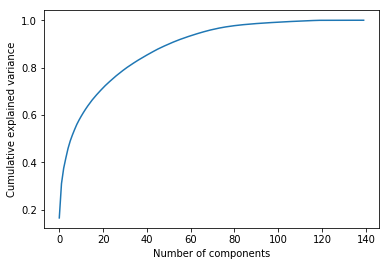

In [14]:
pca = PCA(n_components=140)
pca.fit(Xtr_mini)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [15]:
NCOMPONENTS = 100

pca = PCA(n_components=NCOMPONENTS)
Xtr_pca = pca.fit_transform(Xtr_mini)
X_test_pca = pca.transform(X_test_mini)
pca_std = np.std(Xtr_pca)

print(Xtr_mini.shape)
print(Xtr_pca.shape)

(3200, 140)
(3200, 100)


In [16]:
# Create batches
train_data, train_labels, valid_data, valid_labels = prepare_for_backprop(batch_size, Xtr_mini, Ltr_mini, X_test_mini, L_test_mini)

Creating data...
This is : 3200
Batch size 400, the number of examples 3200.
This is : 800
Batch size 400, the number of examples 800.
Done!


# Multi Layer Perception

Initializing input layer with size 140.
Initializing hidden layer with size 20.
Initializing output layer with size 4.
Done!
Training for 120 epochs...
[   0]  Training error: 0.75000 Test error: 0.75000 Accuracy: 0.25000
[   1]  Training error: 0.75000 Test error: 0.75000 Accuracy: 0.25000
[   2]  Training error: 0.75000 Test error: 0.75000 Accuracy: 0.25000
[   3]  Training error: 0.75000 Test error: 0.75000 Accuracy: 0.25000
[   4]  Training error: 0.75000 Test error: 0.75000 Accuracy: 0.25000
[   5]  Training error: 0.71750 Test error: 0.71375 Accuracy: 0.28625
[   6]  Training error: 0.49594 Test error: 0.47625 Accuracy: 0.52375
[   7]  Training error: 0.47063 Test error: 0.41875 Accuracy: 0.58125
[   8]  Training error: 0.44000 Test error: 0.39625 Accuracy: 0.60375
[   9]  Training error: 0.42219 Test error: 0.39000 Accuracy: 0.61000
[  10]  Training error: 0.40969 Test error: 0.38500 Accuracy: 0.61500
[  11]  Training error: 0.39969 Test error: 0.37875 Accuracy: 0.62125
[  12]  

[ 117]  Training error: 0.16125 Test error: 0.27625 Accuracy: 0.72375
[ 118]  Training error: 0.16125 Test error: 0.27625 Accuracy: 0.72375
[ 119]  Training error: 0.16125 Test error: 0.27625 Accuracy: 0.72375
119
True
Done:)



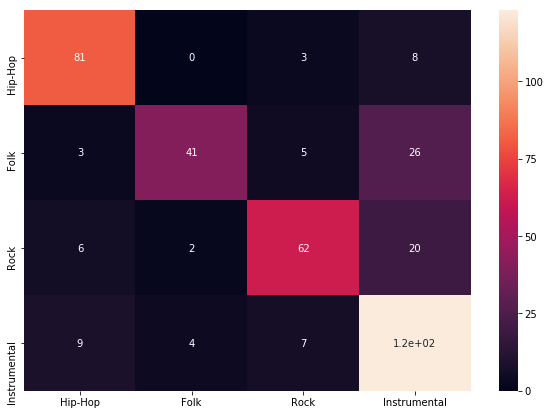

In [29]:
mlp = MultiLayerPerceptron(input_genres,layer_config=[140,20, len(input_genres)], batch_size=batch_size,CM=True)

mlp.evaluate(train_data, train_labels, valid_data, valid_labels,eta=0.001,
             eval_train=True)

print("Done:)\n")